In [50]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [51]:
import glob
import os
import PIL
import time

from IPython import display

In [52]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [53]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [54]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [56]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

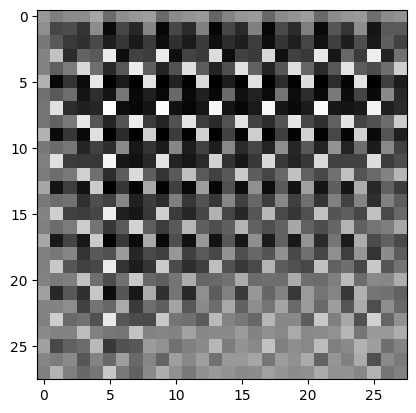

In [57]:
noi = tf.random.normal([1, 100])
sample = checkpoint.generator(noi, training=False)
plt.imshow(sample[0, :, :, 0], cmap='gray')

In [58]:
disc = checkpoint.discriminator
disc.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)             

In [59]:
val = disc(sample)
print (val)

tf.Tensor([[-0.03843365]], shape=(1, 1), dtype=float32)


In [60]:
new_model = Sequential()

for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

# Freeze the layers 
for layer in new_model.layers:
    layer.trainable = False    
    
new_model.add(Dense(2, activation='softmax'))
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)             

In [61]:

new_model.layers[-1].weights

[<tf.Variable 'dense_8/kernel:0' shape=(6272, 2) dtype=float32, numpy=
 array([[ 0.02232701, -0.02942179],
        [ 0.01137393,  0.02672399],
        [-0.01418339,  0.00167212],
        ...,
        [-0.01972076,  0.02986229],
        [-0.02024342, -0.00981872],
        [ 0.01476294, -0.00434264]], dtype=float32)>,
 <tf.Variable 'dense_8/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

In [62]:
import os
from PIL import Image
import numpy as np

# Set the path to your data directory
data_dir = 'data/'
categories = ['happy', 'sad']

# Initialize lists to store images and labels
train_img = []
train_lb = []

# Iterate over each category
for label, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Load the image
            img_path = os.path.join(category_dir, filename)
            image = Image.open(img_path).convert('L')  # Convert to grayscale
            image = image.resize((28, 28))  # Resize to 28x28 pixels (same as MNIST)
            img_array = np.array(image)
            
            # Append image and label to the lists
            train_img.append(img_array)
            train_lb.append(label)

# Convert lists to numpy arrays
train_img = np.array(train_img)
train_lb = np.array(train_lb)

# Now, train_img and train_lb contain your images and labels


In [63]:
from sklearn.model_selection import train_test_split


In [64]:
train_img, test_img, train_lb, test_lb = train_test_split(train_img, train_lb, test_size=0.2, random_state=42)

In [65]:
# (train_img, train_lb), (test_img, test_lb) = tf.keras.datasets.mnist.load_data()

print(train_img.shape, train_lb.shape, test_img.shape, test_lb.shape, '\n')

# set random seed
# randtrain = np.random.choice(train_img.shape[0], trainsize, replace=False)
X_train, y_train = train_img, train_lb

# randtest = np.random.choice(test_img.shape[0], testsize, replace=False)
X_test, y_test = test_img, test_lb

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(93, 28, 28) (93,) (24, 28, 28) (24,) 

(93, 28, 28) (93,) (24, 28, 28) (24,)


In [66]:
y_train

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1])

In [67]:
train_labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [68]:
print(len(X_train))
print(len(y_train))

93
93


In [74]:
# train_images = X_train.reshape((trainsize, 28, 28, 1))
X_train = (X_train.astype('float32') - 127.5) / 127.5

# test_images = X_test.reshape((testsize, 28, 28, 1))
X_test = (X_test.astype('float32') - 127.5) / 127.5

train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = new_model.fit(X_train, train_labels, batch_size=100, epochs=100,
                        validation_data=(X_test, test_labels))


Epoch 1/100
1/1 [==============================] - 1s 784ms/step - loss: 0.6416 - accuracy: 0.6882 - val_loss: 0.6038 - val_accuracy: 0.7083
Epoch 2/100
1/1 [==============================] - 0s 77ms/step - loss: 0.6050 - accuracy: 0.6989 - val_loss: 0.6037 - val_accuracy: 0.7083
Epoch 3/100
1/1 [==============================] - 0s 92ms/step - loss: 0.6373 - accuracy: 0.6989 - val_loss: 0.6036 - val_accuracy: 0.7083
Epoch 4/100
1/1 [==============================] - 0s 93ms/step - loss: 0.6345 - accuracy: 0.6989 - val_loss: 0.6037 - val_accuracy: 0.7083
Epoch 5/100
1/1 [==============================] - 0s 85ms/step - loss: 0.6442 - accuracy: 0.6989 - val_loss: 0.6040 - val_accuracy: 0.7083
Epoch 6/100
1/1 [==============================] - 0s 73ms/step - loss: 0.6366 - accuracy: 0.6989 - val_loss: 0.6038 - val_accuracy: 0.7083
Epoch 7/100
1/1 [==============================] - 0s 71ms/step - loss: 0.6289 - accuracy: 0.6989 - val_loss: 0.6036 - val_accuracy: 0.7083
Epoch 8/100
1/1 [==

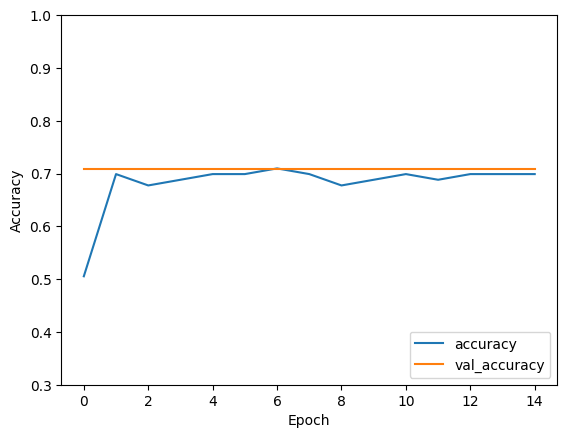

In [71]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()